Exploration of RISE with mnist binary

Function : Exploration of RISE mnist binary
Author : Team DIANNA
Contributor :
First Built : 2021.08.25
Last Update : 2021.08.25
Note : We ran the method using the our own trained model on mnist and various instances from mnist dataset. Results look random. There is no sense that we can make of the heatmaps.

In [1]:
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import softmax
import pandas as pd
from dianna.methods import RISE
from dianna import visualization

In [2]:
data = np.load('./binary-mnist.npz')
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1])/255
y_test = data['y_test']

# Predict classes for test data

In [3]:
def run_model(data):
    data = data.reshape([-1, 1, 28, 28]).astype(np.float32)*255
    fname = './mnist_model.onnx'
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)


pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data

[1.0000000e+00 1.0304685e-16]


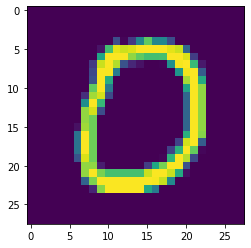

In [4]:
i_instance = 3
print(pred_onnx[i_instance])
plt.imshow(X_test[i_instance][...,0])  # 0 for channel

In [5]:
# heatmaps = dianna.explain(run_model, X_test[[i_instance]], method="RISE", n_masks=2000, feature_res=8, p_keep=0.5)

In [56]:
# investigate which value for p_keep works best by looking at the stddev of the probabilities for the target class,
def print_stats(p_keep):
    n_masks = 500
    feature_res = 8
    explainer = RISE(n_masks=n_masks, feature_res=feature_res, p_keep=p_keep)
    explainer(run_model, X_test[[i_instance]])
    preds = explainer.predictions[:, y_test[i_instance]]
    df = pd.DataFrame(preds)
    display(df.describe())

# print_stats(.5)  # stddev = .006 -> too low
# print_stats(.3)  # .1 -> still a bit low
print_stats(.1)  # .26, with minimum probability of .56 and max of 1.0. This may be ok

Explaining: 100%|██████████| 5/5 [00:00<00:00, 119.07it/s]


,0
count,500.000000
mean,0.781499
std,0.255905
min,0.103158
25%,0.561676
50%,0.925840
75%,0.998255
max,1.000000


In [61]:
explainer = RISE(n_masks=5000, feature_res=8, p_keep=.1)
heatmaps = explainer(run_model, X_test[[i_instance]])

Explaining: 100%|██████████| 50/50 [00:00<00:00, 131.41it/s]


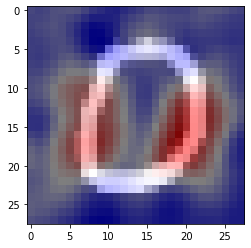

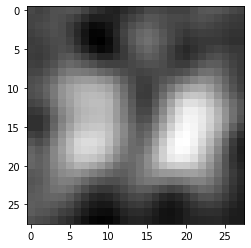

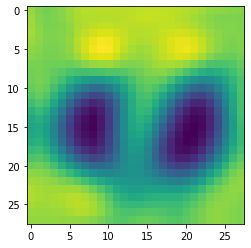

In [62]:
visualization.plot_image(heatmaps[0], X_test[i_instance], data_cmap='gray', heatmap_cmap='bwr')
visualization.plot_image(heatmaps[0], heatmap_cmap='gray')
visualization.plot_image(heatmaps[1])

# Conclusion
We see that for this zero, the left and right parts of it are most important to determine the class. This makes sense, as a one would not have signal in those regions. For higher values of p_keep, the probability does not change enough for RISE to give sensible results, so this parameter needs to be checked/tuned. With proper values for p_keep, RISE thus seems to work.

In [63]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[0])
describe(heatmaps[1])

shape: (28, 28) min: 0.7090325995577501 max: 0.9925079555076913 std: 0.06211205164501536
shape: (28, 28) min: 0.011478949987205294 max: 0.26451279762482766 std: 0.06483113378816897


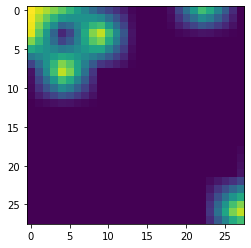

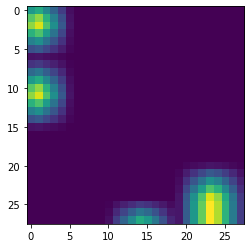

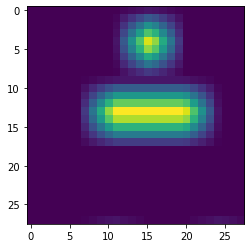

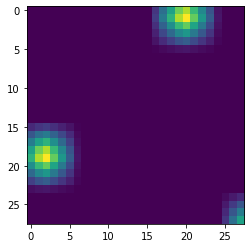

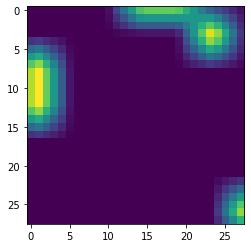

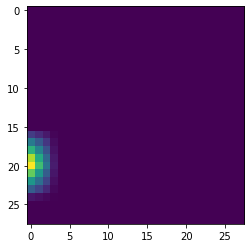

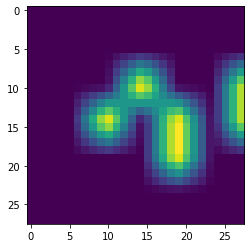

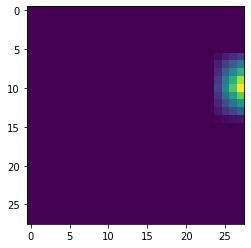

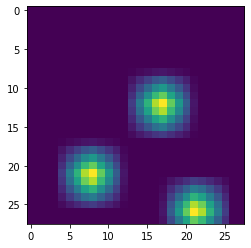

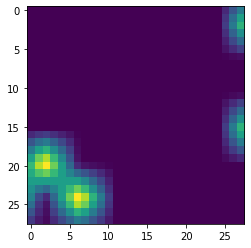

In [64]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()